# data source

https://drive.google.com/drive/folders/1410iMmQCXbA9GJP5CqLEMfjjv-hOWlac?usp=sharing

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#!sudo apt install tesseract-ocr
#!pip install pytesseract

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
import pytesseract
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from google.colab.patches import cv2_imshow

In [2]:
# originalImage = "/content/drive/MyDrive/case study - II/tablenet/data/Marmot_data/10.1.1.1.2006_3.bmp"
# imageMask = "/content/drive/MyDrive/case study - II/tablenet/data/Marmot_data/10.1.1.1.2006_3.xml"
# fileSavepath = "/content/drive/MyDrive/case study - II/tablenet/data/final data/"
# table_mask_path = "/content/drive/MyDrive/case study - II/tablenet/data/final data/tablemask/"
# col_mask_path = "/content/drive/MyDrive/case study - II/tablenet/data/final data/colmask/"
# org_image_path = "/content/drive/MyDrive/case study - II/tablenet/data/final data/orgimage/"
# dataPath = "/content/drive/MyDrive/case study - II/tablenet/data/Marmot_data/"

originalImage = "/Users/rahul/Downloads/tablenet/Marmot_data/10.1.1.1.2006_3.bmp"
imageMask = "/Users/rahul/Downloads/tablenet/Marmot_data/10.1.1.1.2006_3.xml"
fileSavepath = "/Users/rahul/Downloads/tablenet/final data/"
table_mask_path = "/Users/rahul/Downloads/tablenet/final data/tablemask/"
col_mask_path = "/Users/rahul/Downloads/tablenet/final data/colmask/"
org_image_path = "/Users/rahul/Downloads/tablenet/final data/orgimage/"
dataPath = "/Users/rahul/Downloads/tablenet/Marmot_data/"



In [3]:
"""
CREATE DATAFRAME OF PATHS.
dataframe
---------
image_path, xml_path 

* go through every file in mamoth folder (dataPath).
* check a .bmp file, extract name, check if .xml file is present or not --> store in row
"""

image_xml_dict = {"image_path":[], "xml_path":[]}

for file in os.listdir(dataPath):
  if ".bmp" in file:
    name = file.split(".bmp")[0]
    if os.path.exists(dataPath+name+".xml"):
      image_xml_dict['image_path'].append(name+".bmp")
      image_xml_dict['xml_path'].append(name+".xml")


image_xml_df = pd.DataFrame(image_xml_dict)

image_xml_df.head(2)



,image_path,xml_path
0,10.1.1.1.2006_3.bmp,10.1.1.1.2006_3.xml
1,10.1.1.1.2013_63.bmp,10.1.1.1.2013_63.xml


In [4]:
"""
<size>
		<width>793</width>
		<height>1123</height>
		<depth>3</depth>
</size>


<object>
		<name>column</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>458</xmin>
			<ymin>710</ymin>
			<xmax>517</xmax>
			<ymax>785</ymax>
		</bndbox>
	</object>


"""

# /content/drive/MyDrive/case study - II/tablenet/data/final data/

def euc_dist(point1, point2):
    dist = np.linalg.norm(point1 - point2)
    return dist

def show_image_plt(image_arr):
  plt.figure(figsize=(5,5))
  plt.imshow(image_arr)
  plt.show()

def save_image(name, image_arr):
  im = Image.fromarray(image_arr)
  im.save(name)


final_dataframe_dict = {"image":[], "table_mask":[], "col_mask":[]}

for index, row in image_xml_df.iterrows():


    # per row --> xml_path
    org_img_mask_xml = row['xml_path'] # .xml path
    image = dataPath + row['image_path'] # image .bmp path

    # file name
    name = org_img_mask_xml.split(".xml")[0]
    

    # reading xml file
    tree = ET.parse(dataPath + org_img_mask_xml)
    root = tree.getroot()


    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)

    # creating empty mask image
    col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

  # finding objects
    objects = tree.findall('object')
    table_xmin = 0
    table_ymin = 0
    table_xmax = 0
    table_ymax = 0
    prev_dist = 0
    dist = 0
    forward_flag = False
    backward_flag = False
    newtable_flag = True

    # creating empty mask image
    col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

    plt.figure(figsize=(5, 5))

    objects = tree.findall('object')

    for index, object in enumerate(objects):
        
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        
        col_mask_empty[ymin:ymax, xmin:xmax] = 255
        
        
        
        if index == 0:
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            
            
        else:  
                
            
            if xmin > prev_xmin and newtable_flag:
                

                table_xmin = prev_xmin
                table_ymin = prev_ymin
                newtable_flag = False
                forward_flag = True
                backward_flag = False

            if xmin < prev_xmin and newtable_flag:
                
                
                table_xmax = prev_xmax
                table_ymax = prev_ymax
                
                
                newtable_flag = False
                backward_flag = True
                forward_flag = False



            if forward_flag:
                dist = euc_dist(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:

                    if int(np.divide(dist, prev_dist)) > 5:
                        newtable_flag = True
                        table_mask_empty[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255

                        prev_dist = 0
                        
                    if index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[table_ymin:ymax, table_xmin:xmax] = 255

                        prev_dist = 0

            if backward_flag:
                dist = euc_dist(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:
                    if int(np.divide(dist, prev_dist)) > 5 or index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[ymin:table_ymax, xmin:table_xmax] = 255
                        prev_dist = 0
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            prev_dist = dist
            

    save_image(table_mask_path+ name+".jpeg", table_mask_empty)
    save_image(col_mask_path + name+".jpeg", col_mask_empty)

    final_dataframe_dict['table_mask'].append(table_mask_path+ name+".jpeg")
    final_dataframe_dict['col_mask'].append(col_mask_path + name+".jpeg")
    final_dataframe_dict['image'].append(image)



# creating dataframe --> (oroginal_image, table_mask, col_mask)
final_dataframe = pd.DataFrame(final_dataframe_dict)
final_dataframe.head(2)
final_dataframe.to_csv("/Users/rahul/Downloads/tablenet/final_dataframe.csv", index=False)


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

# reading dataframe

In [5]:
final_dataframe = pd.read_csv("/Users/rahul/Downloads/tablenet/final_dataframe.csv")
final_dataframe.head(2)

,image,table_mask,col_mask
0,/Users/rahul/Downloads/tablenet/Marmot_data/10...,/Users/rahul/Downloads/tablenet/final data/tab...,/Users/rahul/Downloads/tablenet/final data/col...
1,/Users/rahul/Downloads/tablenet/Marmot_data/10...,/Users/rahul/Downloads/tablenet/final data/tab...,/Users/rahul/Downloads/tablenet/final data/col...


# data generator

In [6]:
X_train, X_test = train_test_split(final_dataframe, test_size=0.2)

In [7]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train['image'].values, tf.string),
            tf.cast(X_train['table_mask'].values, tf.string),
            tf.cast(X_train['col_mask'].values, tf.string),
        )
    )
)



testing_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test['image'].values, tf.string),
            tf.cast(X_test['table_mask'].values, tf.string),
            tf.cast(X_test['col_mask'].values, tf.string),
        )
    )
)



In [8]:
# https://www.tensorflow.org/tutorials/load_data/images

@tf.function
def load_image(image, table_mask, col_mask):

    image = tf.io.read_file(image)
    table_mask=tf.io.read_file(table_mask)
    col_mask=tf.io.read_file(col_mask)

    image=tf.io.decode_bmp(image, channels=3)
    image=tf.image.resize(image, [1024, 1024])
    image = tf.cast(image, tf.float32) / 255.0

    table_mask=tf.io.decode_jpeg(table_mask, channels=1)
    table_mask=tf.image.resize(table_mask, [1024, 1024])
    table_mask = table_mask / 255.0
    

    col_mask=tf.io.decode_jpeg(col_mask, channels=1)
    col_mask=tf.image.resize(col_mask, [1024, 1024])
    col_mask = col_mask / 255.0

    return image, {"table_mask":table_mask, "col_mask":col_mask}



# creating dataset object
train = training_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = testing_dataset.map(load_image)



In [9]:
BATCH_SIZE = 2
BUFFER_SIZE = 10
train_steps = len(X_train) // BATCH_SIZE

# for feeding to training
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

(1024, 1024, 3)
(1024, 1024, 1)
(1024, 1024, 1)


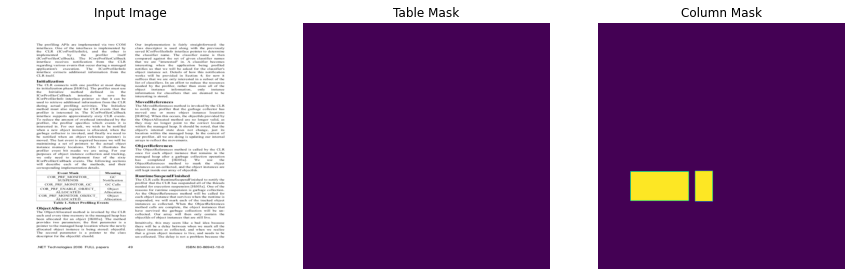

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask', 'Masked image']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        image = display_list[i]

        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.axis('off')
    plt.show()



for image, mask in train.take(1):

    sample_image = image
    sample_table_mask = mask['table_mask']
    sample_col_mask = mask['col_mask']


    print(image.shape)
    print(mask['table_mask'].shape)
    print(mask['col_mask'].shape)
    display([image, mask['table_mask'], mask['col_mask']])

# model

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [12]:
"""
Table decoder
-------------
x = conv7(1x1)
x = x(upscaled) + vgg19(pool4)
x = x(upscaled) + vgg19(pool3)
x = upscaled to match input dimention (1024)


column decoder
--------------
x = conv7(1x1, relu)
x = dropout(0.8)
x = conv8(1x1)
x = upscaled() + vgg19(pool4)
x = x(upscaled) + vgg19(pool3)
x = upscaled (1024)

"""


tf.keras.backend.clear_session()


class table_mask(Layer):

    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.002))
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        
        x = self.conv_7(input)
        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
       
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)

        x = self.upsample_final(x)

       

        return x

class col_mask(Layer):
    
    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',)
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',)
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        
        x = self.conv_7(input)
        x = self.drop(x)
        x = self.conv_8(x)

        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
       
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)

        x = self.upsample_final(x)

        

        return x



input_shape = (1024, 1024, 3)
input_ = Input(shape=input_shape)

vgg19_ = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

for layer in vgg19_.layers:
    layer.trainable = False

pool3 = vgg19_.get_layer('block3_pool').output
pool4 = vgg19_.get_layer('block4_pool').output

conv_1_1_1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv1", kernel_regularizer=tf.keras.regularizers.l2(0.004))(vgg19_.output)
conv_1_1_1_drop = Dropout(0.8)(conv_1_1_1)

conv_1_1_2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv2", kernel_regularizer=tf.keras.regularizers.l2(0.004))(conv_1_1_1_drop)
conv_1_1_2_drop = Dropout(0.8)(conv_1_1_2)

table_mask = table_mask()(conv_1_1_2_drop, pool3, pool4)
col_mask = col_mask()(conv_1_1_2_drop, pool3, pool4)

model = Model(input_, [table_mask, col_mask])

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, 1024, 1024,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, 1024, 1024,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

In [16]:
plot_model(model,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# model trainning

In [13]:
losses = {
    "table_mask": 'sparse_categorical_crossentropy',
    "col_mask": 'sparse_categorical_crossentropy',
}

# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



filepath = "/content/drive/MyDrive/model checkpoint/table_net.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = "val_table_mask_loss", save_best_only=True, verbose = 0, mode="min")

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,)


class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, tf.argmax(y_pred, axis=-1))
        r = self.recall_fn(y_true, tf.argmax(y_pred, axis=-1))
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)


metrics = [F1_Score()]

global init_lr
init_lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr, epsilon=1e-8,),
              loss=losses,
              metrics=metrics, )


In [15]:


def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(1):
            table_mask_pred, col_mask_pred = model.predict(image)

            table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
            table_mask_pred = table_mask_pred[..., tf.newaxis][0]

            col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
            col_mask_pred = col_mask_pred[..., tf.newaxis][0]

            im=tf.keras.preprocessing.image.array_to_img(image[0])
            im.save('image.png')

            im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
            im.save('table_mask_pred.png')

            im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
            im.save('col_mask_pred.png')



            img_org = Image.open('./image.png')
            table_mask = Image.open('./table_mask_pred.png')
            col_mask = Image.open('./col_mask_pred.png')


            # convert images
            img_mask = table_mask.convert('L')
            # img_mask = col_mask.convert('L')

            # grayscale
            # add alpha channel
            img_org.putalpha(img_mask)

            # save as png which keeps alpha channel
            img_org.save('output.png')


            display([image[0], table_mask_pred, col_mask_pred, img_org])

            pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
            text = pytesseract.image_to_string(Image.open('./output.png'), lang='eng' ) # config='--psm 11'
            print(text)



class DisplayCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.history = {'val_table_mask_loss':[]}
        self.init_lr = init_lr

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            show_predictions(test_dataset, 1)
            
            
            self.history['val_table_mask_loss'].append(logs.get('val_table_mask_loss'))
            if epoch > 2:
                cur_loss = self.history['val_table_mask_loss'][epoch]
                prev_loss = self.history['val_table_mask_loss'][epoch-1]

                if cur_loss > prev_loss:
                    self.init_lr = self.init_lr * 0.93
                    K.set_value(self.model.optimizer.learning_rate, self.init_lr)

Epoch 1/50
1/1 [==============================] - 7s 7s/steps - loss: 3.0313 - table_mask_loss: 0.3698 - col_mask_loss: 0.3243 - table_mask_f1_score: 0.5403 - col_mask_f1_score: 0.44


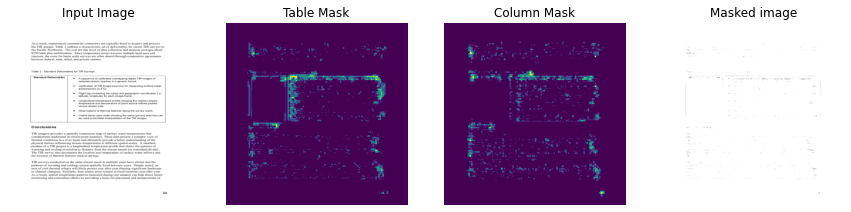

TesseractNotFoundError: /usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.

In [17]:
EPOCHS = 50
VAL_SUBSPLITS = 30
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(train_dataset,
                              epochs=EPOCHS,
                              steps_per_epoch=train_steps,
                              validation_data=test_dataset,
                              validation_steps=VALIDATION_STEPS,
                              callbacks=[model_checkpoint, es, DisplayCallback()])

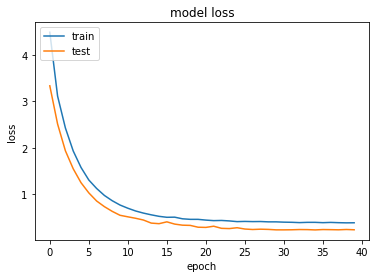

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


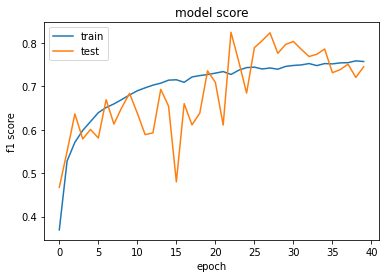

In [ ]:

plt.plot(history.history['table_mask_f1_score'])
plt.plot(history.history['val_table_mask_f1_score'])
plt.title('model score')
plt.ylabel('table f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


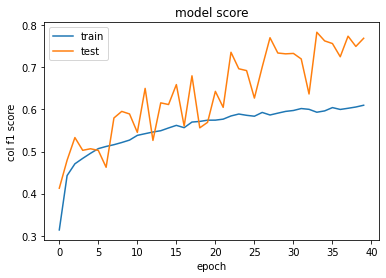

In [ ]:
plt.plot(history.history['col_mask_f1_score'])
plt.plot(history.history['val_col_mask_f1_score'])
plt.title('model score')
plt.ylabel('col f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# prediction

In [21]:

model_path = "/content/drive/MyDrive/model checkpoint/table_net.h5"
model.load_weights(model_path)


(1, 1024, 1024, 3)


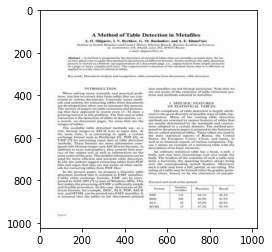

In [22]:
image = cv2.imread('/Users/rahul/Downloads/tablenet/OIP.jpg', cv2.IMREAD_UNCHANGED)
image = cv2.resize(image,(1024, 1024), cv2.INTER_NEAREST)
plt.imshow(image)
image = np.expand_dims(image, axis=0)
print(image.shape)

In [23]:
table_mask_pred, col_mask_pred = model.predict(image)

table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
table_mask_pred = table_mask_pred[..., tf.newaxis][0]

col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
col_mask_pred = col_mask_pred[..., tf.newaxis][0]

im=tf.keras.preprocessing.image.array_to_img(image[0])
im.save('image.png')

im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
im.save('table_mask_pred.png')

im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
im.save('col_mask_pred.png')

1/1 [==============================] - 3s 3s/step


(2, 1024, 1024, 3)
1/1 [==============================] - 5s 5s/step


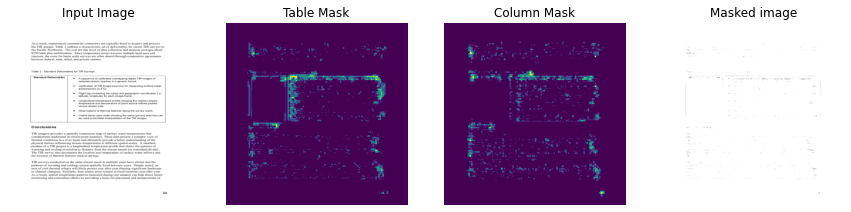

TesseractNotFoundError: /usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.

In [24]:
count = 0

for image, mask in test_dataset.take(10):


    print(image.shape)

    table_mask_pred, col_mask_pred = model.predict(image)

    table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
    table_mask_pred = table_mask_pred[..., tf.newaxis][0]

    col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
    col_mask_pred = col_mask_pred[..., tf.newaxis][0]

    im=tf.keras.preprocessing.image.array_to_img(image[0])
    im.save('image.png')

    im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
    im.save('table_mask_pred.png')

    im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
    im.save('col_mask_pred.png')



    img_org = Image.open('./image.png')
    table_mask = Image.open('./table_mask_pred.png')
    col_mask = Image.open('./col_mask_pred.png')


    # convert images
    img_mask = table_mask.convert('L')
    # img_mask = col_mask.convert('L')

    # grayscale
    # add alpha channel
    img_org.putalpha(img_mask)

    # save as png which keeps alpha channel
    img_org.save('output.png')


    display([image[0], table_mask_pred, col_mask_pred, img_org])

    pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
    text = pytesseract.image_to_string(Image.open('./output.png'), lang='eng' ) # config='--psm 11'
    print(text)


